# Yu Jie's version of Karpathy's notebook

! look for backprop formulas, so + transfer gradients * takes values and multiply by previous grad, what other formulas, I kept the intermediate work that I used when going through Karpathy's notebook.

Quotes
    most common neural net mistakes: 1) you didn't try to overfit a single batch first. 2) you forgot to toggle train/eval mode for the net. 3) you forgot to .zero_grad() (in pytorch) before .backward(). 4) you passed softmaxed outputs to a loss that expects raw logits. ; others? :)

https://karpathy.github.io/2019/04/25/recipe/

https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b

In [296]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Visualisation

To manually work on backpropagation, we need to visualise the each node.

This is good for understanding the process under the hood, but it is not essential in the construction.

In [ ]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set() # definition of a graph!
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [299]:
# dL / dc  (most important point!)
# we know dL / dd, but how is dL / dc?
# dd / dc ? 1.0
# d = c + e;
# f(x + h) - f(x) / h
# focusing on c, ((c + h + e) - (c + e))/h
# (c + h + e - c - e)/h = h/h = 1.0
# by symmetry dd / de = 1.0 (local derivative, knows that it is a + operation, can be embedded in a massive graph)
# dL / dc = (dL / dd) * (dd / dc)
# because by local gradient is 1, just copy over for a + node.
# node just routes the gradient, so + becomes a hom.

# dL / de = -2.0
# e = a * b
# de / da ? b
# dL / da = (dL / de) * (de / da) = -2.0 * b = -2.0 * -3.0 = 6.0
# so chain rule works such that * rule, say dL/db, if dL/dc = 2.0, value of a = 2.0, we have dL/db = a * dL/dc


In [300]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


## Multi-layer perceptron ("MLP")

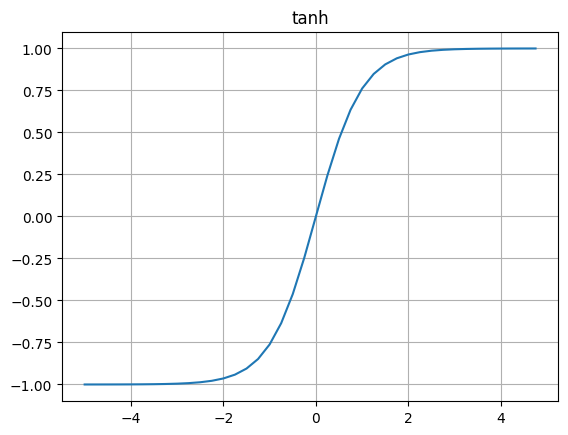

In [301]:
plt.plot(np.arange(-5.0, 5.0, 0.25), np.tanh(np.arange(-5.0, 5.0, 0.25))); plt.title('tanh'); plt.grid();

Here is a visualisation of how the neuron will work.

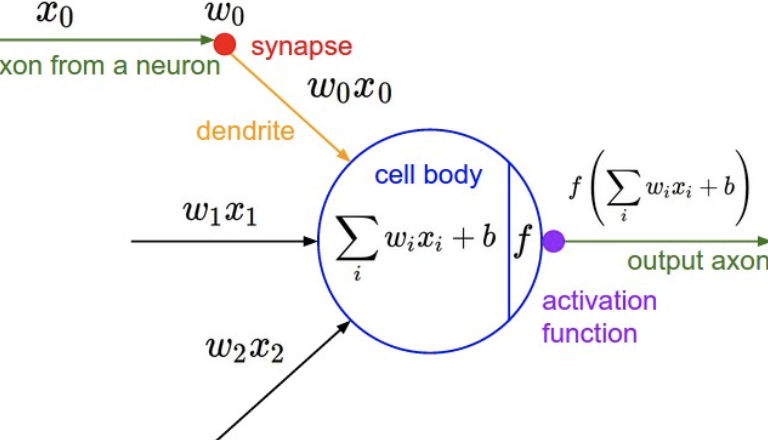

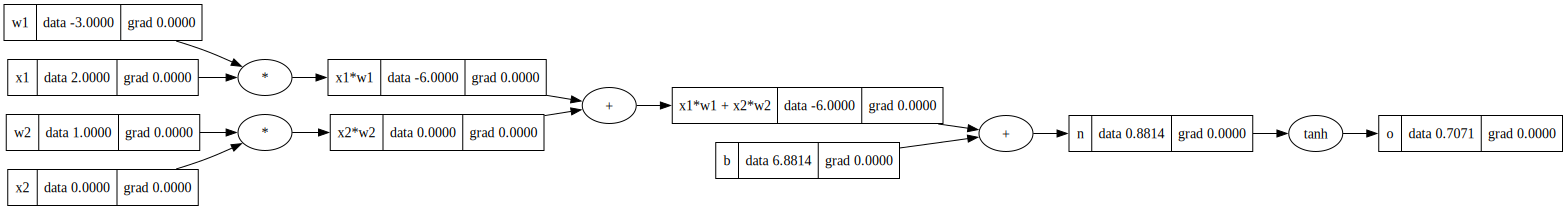

In [302]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron, say 6.8813735870195432 to make it output 1.0
b = Value(6.8813735870195432, label='b')
# b = Value(8.0, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# reason to implement tanh is because it is differentiable everywhere, smooth gradient, outputs bound between -1 and 1, centered around 0
# alternatives are ReLU, leaky ReLU, sigmoid
# o is short for output.
o = n.tanh(); o.label = 'o'
draw_dot(o)

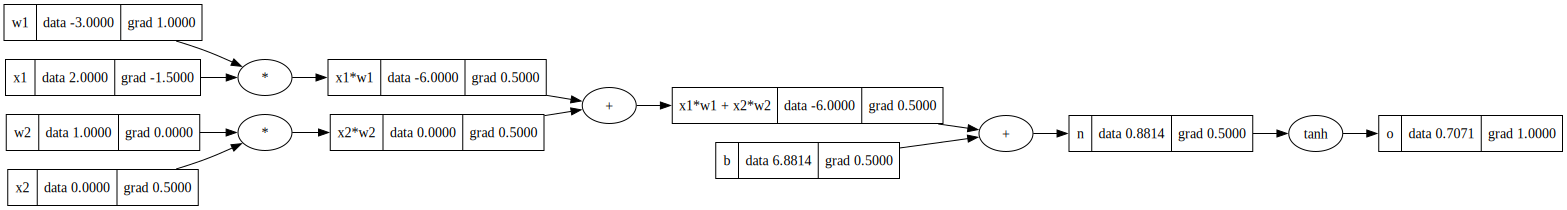

In [303]:
o.grad = 1.0 # why? this because do chain rule, dL/dL = 1.0
o._backward()
n._backward()
b._backward() # nothing will happen
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
draw_dot(o)

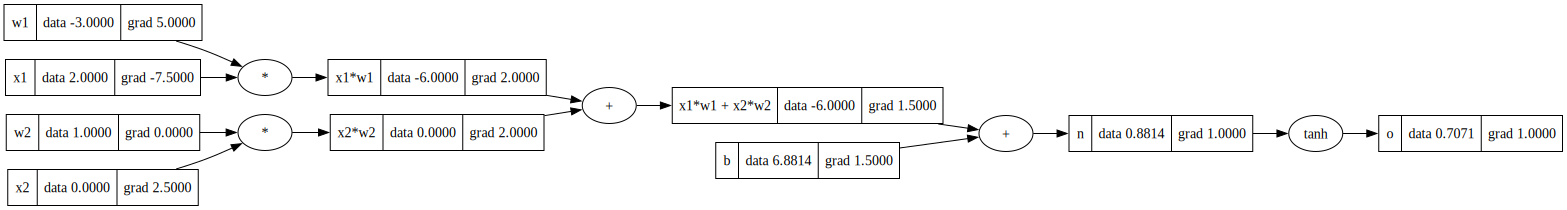

In [304]:
o.backward()
draw_dot(o)

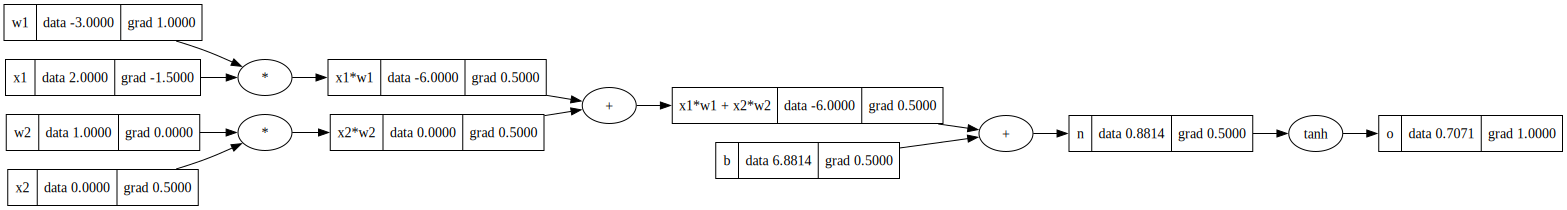

In [305]:
# manual backprop solutions
o.grad = 1.0
# step 1: o = tanh(n)
# 1 - tanh^2 x, motivates why it is easy to use tanh
# n.grad = (1 - o.data**2) * o.grad

# n.grad = 0.5
n.grad = (1 - o.data**2) * o.grad;

# for a + node, remembering it is just distributor of gradients
# so just copy over the gradient
# n = x1w1x2w2 + b
x1w1x2w2.grad = 1.0 * n.grad #0.5
b.grad = 1.0 * n.grad # 0.5

# again for a + node, rem embering it is just distributor of gradients
# so just copy over the gradient
x1w1.grad = 1.0 * x1w1x2w2.grad # 0.5
x2w2.grad = 1.0 * x1w1x2w2.grad # 0.5

# for a * node, it will just multiply by the other value
# x1w1 = x1 * w1
x1.grad = w1.data * x1w1.grad # -3.0 * 0.5
w1.grad = x1.data * x1w1.grad # 2.0 * 0.5

# x2w2 = x2 * w2
x2.grad = w2.data * x2w2.grad # 1.0 *
w2.grad = x2.data * x2w2.grad # 0.0 *, notice that x2 is 0.0, so w2.grad is 0.0 since w2 is not contributing to the output

draw_dot(o)

# note this is different from Karpathy's version for x1 w1, but the principles are the same

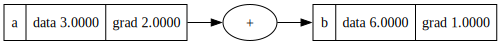

In [306]:
# bad bug, a + a
# gradient is overwritten with naive implementation
# problem when you have the same variable used multiple times
# solution is to accumulate the gradients instead of overwriting them

a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

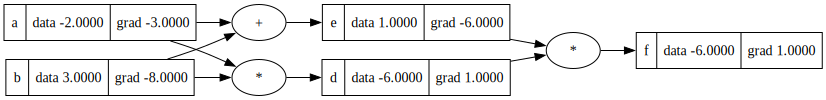

In [307]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

you can implement it at any levels
all that matters, input, output, forward pass, backward pass, does not matter what that operation is, gradient

In [308]:
import torch

# default requires_grad is False
# requires_grad is like setting up the graph to track gradients
# if you do not need gradients, do not set requires_grad to True
# saves memory and computation

w1 = torch.tensor(-3.0, requires_grad=True)
x1 = torch.tensor(2.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)
# b = torch.tensor(8.0, requires_grad=True)
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x2w2 = x2 * w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = torch.tanh(n)
o.backward()

print('x1.grad: ', x1.grad.item())
print('w1.grad: ', w1.grad.item())
print('x2.grad: ', x2.grad.item())
print('w2.grad: ', w2.grad.item())

torch.Tensor([2, 0]).double().dtype 

x1.grad:  -1.5000003576278687
w1.grad:  1.000000238418579
x2.grad:  0.5000001192092896
w2.grad:  0.0


torch.float64

# two layer multilayer perceptron

In [309]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [310]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.5156398107372903)

In [311]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [312]:
ypred = [n(x) for x in xs]
loss   = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.007001436716267)

In [313]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

ypred = [n(x) for x in xs]
loss   = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

for k in range(100):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass

  # this is a very very subtle bug, you need to .zero grad. make sure that p.grad is set to 0 before calling backward
  # reason: just like pytorch, gradients are accumulated into .grad variable, so if you do not zero it, it will keep accumulating
  
  # What happened was Karpathy missed this subtle but important step, and his code was wrong for a while.
  
  for p in n.parameters():
    p.grad = 0.0

  # this is so that the actual backward pass accumulates
  loss.backward()
  
  # update
  for p in n.parameters():
    rate = -0.1 # tweak this
    # try different learning rates -0.9
    p.data += rate * p.grad
  
  print(k, loss.data)
  

0 1.657525112470506
1 2.751749827281572
2 2.4385947778642154
3 0.03294791028719624
4 0.026429307791414183
5 0.02219635463529264
6 0.01921291516810008
7 0.0169916520047474
8 0.015271159358053715
9 0.013897974606768358
10 0.012775822848428289
11 0.011841140615347622
12 0.011050220761552775
13 0.01037199618623763
14 0.009783766117763229
15 0.009268550929579539
16 0.008813393163391182
17 0.008408231302887613
18 0.008045132596490015
19 0.007717757890075672
20 0.007420980407909441
21 0.007150609103203377
22 0.006903184531772384
23 0.00667582596970608
24 0.0064661153528243545
25 0.0062720080804004475
26 0.006091763691774946
27 0.005923891431350579
28 0.005767107098104586
29 0.005620298540204811
30 0.005482497838564034
31 0.005352858713524496
32 0.0052306380450398825
33 0.005115180658338514
34 0.005005906721219759
35 0.004902301244651696
36 0.004803905288388411
37 0.004710308557264969
38 0.004621143138368613
39 0.0045360781792847076
40 0.00445481534662788
41 0.0043770849347132
42 0.00430264251

In [314]:
# mean squared error, but you use cross entropy loss for classification tasks

loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.002330209945378385)

In [315]:
n.layers[0].neurons[0].w[0].data

0.5920738543883038

In [316]:
n.layers[0].neurons[0].w[0].grad

0.0005793199298240863

In [317]:
for p in n.parameters():
    p.grad = 0.0